In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

## Import from TimeSeriesSeq2Seq
from architecture.seq2seq import LSTMSeq2Seq, AttentionLSTMSeq2Seq, TransformerSeq2Seq

In [18]:
SEQ_LEN = 30
OUTPUT_LEN = 1
BATCH_SIZE = 32
EPOCHS = 30
LR = 1e-3
HIDDEN_SIZE = 64

In [19]:
CSV_PATH = "/oak/stanford/groups/rondror/users/nishankr/229proj/data/SHEL_data.csv"
FEATURE_COLS = ["Open","High","Low","Close","Adj Close","Volume"]


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
def scaled_rmse(y_true_scaled, y_pred_scaled):
    mse = np.mean((y_true_scaled - y_pred_scaled) ** 2, axis=0)
    rmse = np.sqrt(mse)
    return rmse, float(rmse.mean())

def mape(y_true, y_pred, eps=1e-8):
    denom = np.maximum(np.abs(y_true), eps)
    ape = np.abs((y_pred - y_true) / denom)
    per_feature = ape.mean(axis=0) * 100.0
    overall = float(per_feature.mean())
    return per_feature, overall

def mean_directional_accuracy(y_true, y_pred, full_series, target_indices):
    prev_idx = target_indices - 1
    prev_vals = full_series[prev_idx]
    actual_change = np.sign(y_true - prev_vals)
    pred_change   = np.sign(y_pred - prev_vals)
    mask = actual_change != 0
    matches = (actual_change == pred_change) & mask
    per_feature = np.zeros(y_true.shape[1])
    for d in range(y_true.shape[1]):
        if mask[:, d].sum() == 0:
            per_feature[d] = np.nan
        else:
            per_feature[d] = matches[:, d].sum() / mask[:, d].sum()
    overall = matches.sum() / np.maximum(mask.sum(), 1)
    return per_feature, float(overall)

def r2_score_multi(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2, axis=0)
    ss_tot = np.sum((y_true - y_true.mean(axis=0)) ** 2, axis=0)
    per_feature = 1.0 - ss_res / ss_tot
    overall = 1.0 - ss_res.sum() / ss_tot.sum()
    return per_feature, float(overall)

def forecast_bias(y_true, y_pred, tol_frac=0.01):
    errors = y_pred - y_true
    mean_err = errors.mean(axis=0)
    mean_abs = np.mean(np.abs(y_true), axis=0) + 1e-8
    labels = []
    for m, ma in zip(mean_err, mean_abs):
        tol = tol_frac * ma
        if m > tol:
            labels.append("Positive bias (over-forecast)")
        elif m < -tol:
            labels.append("Negative bias (under-forecast)")
        else:
            labels.append("Near-unbiased")
    return mean_err, labels

def plot_overlays(y_true, y_pred, feature_names):
    n_features = y_true.shape[1]
    x = np.arange(y_true.shape[0])
    fig, axes = plt.subplots(n_features, 1, figsize=(12, 3 * n_features), sharex=True)
    if n_features == 1:
        axes = [axes]
    for i, ax in enumerate(axes):
        ax.plot(x, y_true[:, i], label=f"True {feature_names[i]}")
        ax.plot(x, y_pred[:, i], label=f"Pred {feature_names[i]}")
        ax.set_ylabel(feature_names[i])
        ax.grid(True, alpha=0.3)
        ax.legend(loc="best")
    axes[-1].set_xlabel("Test window index (time)")
    fig.tight_layout()
    plt.show()

In [22]:
df = pd.read_csv(CSV_PATH, parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

values = df[FEATURE_COLS].values.astype(np.float32)
T, D = values.shape
print("Total timesteps:", T, "Features:", D)

split_idx = int(T * 0.9)

scaler = StandardScaler()
scaler.fit(values[:split_idx])
values_scaled = scaler.transform(values).astype(np.float32)

Total timesteps: 977 Features: 6


In [23]:
X_list, y_list, idx_list = [], [], []
for t in range(SEQ_LEN, T - OUTPUT_LEN + 1):
    X_list.append(values_scaled[t - SEQ_LEN : t])
    y_list.append(values_scaled[t : t + OUTPUT_LEN].reshape(-1, D)) ## shape (1, D)
    idx_list.append(t)

X = np.stack(X_list, axis=0) ## [N, SEQ_LEN, D]
y = np.stack(y_list, axis=0) ## [N, 1, D]
indices = np.array(idx_list)

train_mask = indices < split_idx
test_mask  = indices >= split_idx

In [24]:
X_train, y_train, idx_train = X[train_mask], y[train_mask, 0, :], indices[train_mask]
X_test,  y_test,  idx_test  = X[test_mask],  y[test_mask, 0, :],  indices[test_mask]

In [25]:
print("Train windows:", X_train.shape[0], "Test windows:", X_test.shape[0])

Train windows: 849 Test windows: 98


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
model = LSTMSeq2Seq(
    input_size=D,
    output_size=D,
    hidden_size=HIDDEN_SIZE,
    num_layers=1,
    bidirectional=False,
    dropout=0.0,
).to(device)

optim = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

In [28]:

train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

In [29]:
model.train()
for epoch in range(1, EPOCHS + 1):
    epoch_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optim.zero_grad()
        ## Seq2Seq forward: output length = 1, no teacher forcing needed
        preds = model(xb, 1) ## (B, 1, D)
        preds = preds[:, 0, :] ## (B, D)
        loss = loss_fn(preds, yb)
        loss.backward()
        optim.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_ds)
    print(f"Epoch {epoch:03d} | Train MSE: {epoch_loss:.6f}")

Epoch 001 | Train MSE: 0.873591
Epoch 002 | Train MSE: 0.331914
Epoch 003 | Train MSE: 0.196708
Epoch 004 | Train MSE: 0.179375
Epoch 005 | Train MSE: 0.175622
Epoch 006 | Train MSE: 0.174244
Epoch 007 | Train MSE: 0.173613
Epoch 008 | Train MSE: 0.173137
Epoch 009 | Train MSE: 0.172898
Epoch 010 | Train MSE: 0.172496
Epoch 011 | Train MSE: 0.172123
Epoch 012 | Train MSE: 0.172099
Epoch 013 | Train MSE: 0.172233
Epoch 014 | Train MSE: 0.171567
Epoch 015 | Train MSE: 0.171250
Epoch 016 | Train MSE: 0.171090
Epoch 017 | Train MSE: 0.170853
Epoch 018 | Train MSE: 0.170911
Epoch 019 | Train MSE: 0.171175
Epoch 020 | Train MSE: 0.170442
Epoch 021 | Train MSE: 0.170714
Epoch 022 | Train MSE: 0.170557
Epoch 023 | Train MSE: 0.170583
Epoch 024 | Train MSE: 0.170282
Epoch 025 | Train MSE: 0.170231
Epoch 026 | Train MSE: 0.170346
Epoch 027 | Train MSE: 0.169791
Epoch 028 | Train MSE: 0.169634
Epoch 029 | Train MSE: 0.169552
Epoch 030 | Train MSE: 0.169671


In [30]:
model.eval()
with torch.no_grad():
    X_t = torch.from_numpy(X_test).to(device)
    preds = model(X_t, 1).cpu().numpy() ## shape (N_test, 1, D)
    preds = preds[:, 0, :] ## (N_test, D)
 
y_test_scaled = y_test
preds_scaled = preds

## to original units
y_test_orig = scaler.inverse_transform(y_test_scaled)
preds_orig  = scaler.inverse_transform(preds_scaled)

full_orig = values 

In [35]:
rmse_sf, rmse_overall = scaled_rmse(y_test_scaled, preds_scaled)
mape_pf, mape_overall = mape(y_test_orig, preds_orig)
mda_pf, mda_overall = mean_directional_accuracy(
    y_test_orig, preds_orig, full_orig, idx_test
)
r2_pf, r2_overall = r2_score_multi(y_test_orig, preds_orig)
mean_err_pf, bias_labels = forecast_bias(y_test_orig, preds_orig)

print("\n=== HOLDOUT METRICS (Seq2Seq LSTM) ===")
for i, name in enumerate(FEATURE_COLS):
    print(f"\nFeature: {name}")
    print(f"  Scaled RMSE: {rmse_sf[i]:.4f}")
    print(f"  MAPE:        {mape_pf[i]:.2f}%")
    print(f"  MDA:         {mda_pf[i]:.3f}")
    print(f"  R^2:         {r2_pf[i]:.3f}")
    print(f"  Mean error:  {mean_err_pf[i]:.4f}  -> {bias_labels[i]}")


=== HOLDOUT METRICS (Seq2Seq LSTM) ===

Feature: Open
  Scaled RMSE: 0.1296
  MAPE:        1.50%
  MDA:         0.541
  R^2:         0.765
  Mean error:  0.8630  -> Positive bias (over-forecast)

Feature: High
  Scaled RMSE: 0.1238
  MAPE:        1.44%
  MDA:         0.495
  R^2:         0.781
  Mean error:  0.7829  -> Positive bias (over-forecast)

Feature: Low
  Scaled RMSE: 0.1358
  MAPE:        1.54%
  MDA:         0.490
  R^2:         0.749
  Mean error:  0.8752  -> Positive bias (over-forecast)

Feature: Close
  Scaled RMSE: 0.1276
  MAPE:        1.46%
  MDA:         0.480
  R^2:         0.767
  Mean error:  0.7907  -> Positive bias (over-forecast)

Feature: Adj Close
  Scaled RMSE: 0.1291
  MAPE:        1.69%
  MDA:         0.378
  R^2:         0.650
  Mean error:  -0.2219  -> Near-unbiased

Feature: Volume
  Scaled RMSE: 1.0696
  MAPE:        38.73%
  MDA:         0.653
  R^2:         0.048
  Mean error:  299851.0312  -> Positive bias (over-forecast)


In [36]:
def make_results_row(model_name, y_true_scaled, y_pred_scaled,
                     y_true_orig, y_pred_orig,
                     full_orig_series, test_indices):
    """
    model_name: str, e.g. "Seq2Seq_LSTM"
    y_true_scaled, y_pred_scaled: numpy arrays, shape (N_test, D)
    y_true_orig,   y_pred_orig:   numpy arrays, shape (N_test, D)  (un-scaled)
    full_orig_series: full data series in original units, shape (T, D)
    test_indices: 1D array, length N_test, giving the index in full_orig_series
                  for each y_true row (so MDA can compute sign change from previous timestep)
    Returns:
      dict with keys:
        "Model", "Scaled RMSE", "MAPE", "Mean Directional Accuracy (MDA)", "R^2", "Forecast Bias?"
    """
    import numpy as np

    ## Scaled RMSE (mean over features)
    mse = np.mean((y_true_scaled - y_pred_scaled) ** 2, axis=0)
    rmse_series = np.sqrt(mse)
    scaled_rmse = float(rmse_series.mean())

    ## MAPE (mean over all features)
    eps = 1e-8
    ape = np.abs((y_pred_orig - y_true_orig) / np.maximum(np.abs(y_true_orig), eps))
    mape_per_feat = np.mean(ape, axis=0) * 100.0
    mape = float(np.mean(mape_per_feat))

    ## R^2 (flatten across all points)
    ss_res = np.sum((y_true_orig - y_pred_orig) ** 2)
    ss_tot = np.sum((y_true_orig - y_true_orig.mean(axis=0)) ** 2)
    r2 = 1.0 - ss_res / (ss_tot + eps)

    ## Forecast Bias: mean error across all, sign → label
    mean_err = np.mean(y_pred_orig - y_true_orig)
    bias_label = "Over-forecast (too high)" if mean_err > 0 else "Under-forecast (too low)" if mean_err < 0 else "Unbiased"

    ## MDA (overall across features)
    prev_idx = test_indices - 1
    prev_vals = full_orig_series[prev_idx]
    actual_change = np.sign(y_true_orig - prev_vals)
    pred_change   = np.sign(y_pred_orig - prev_vals)
    mask = actual_change != 0
    matches = (actual_change == pred_change) & mask
    ## prevent division by zero
    mda = matches.sum() / max(mask.sum(), 1)

    return {
        "Model": model_name,
        "Scaled RMSE": scaled_rmse,
        "MAPE": mape,
        "Mean Directional Accuracy (MDA)": float(mda),
        "R^2": r2,
        "Forecast Bias?": bias_label
    }

In [37]:
row = make_results_row(
    "Seq2Seq_LSTM",
    y_test_scaled, preds_scaled,
    y_test_orig, preds_orig,
    full_orig, idx_test
)
print(row)

{'Model': 'Seq2Seq_LSTM', 'Scaled RMSE': 0.2859243154525757, 'MAPE': 7.7275261878967285, 'Mean Directional Accuracy (MDA)': 0.5059625212947189, 'R^2': np.float32(0.04836589), 'Forecast Bias?': 'Over-forecast (too high)'}


In [32]:
print("\nOverall (all features combined):")
print(f"  Scaled RMSE (mean): {rmse_overall:.4f}")
print(f"  MAPE (mean):        {mape_overall:.2f}%")
print(f"  MDA (overall):      {mda_overall:.3f}")
print(f"  R^2 (overall):      {r2_overall:.3f}")



Overall (all features combined):
  Scaled RMSE (mean): 0.2859
  MAPE (mean):        7.73%
  MDA (overall):      0.506
  R^2 (overall):      0.048


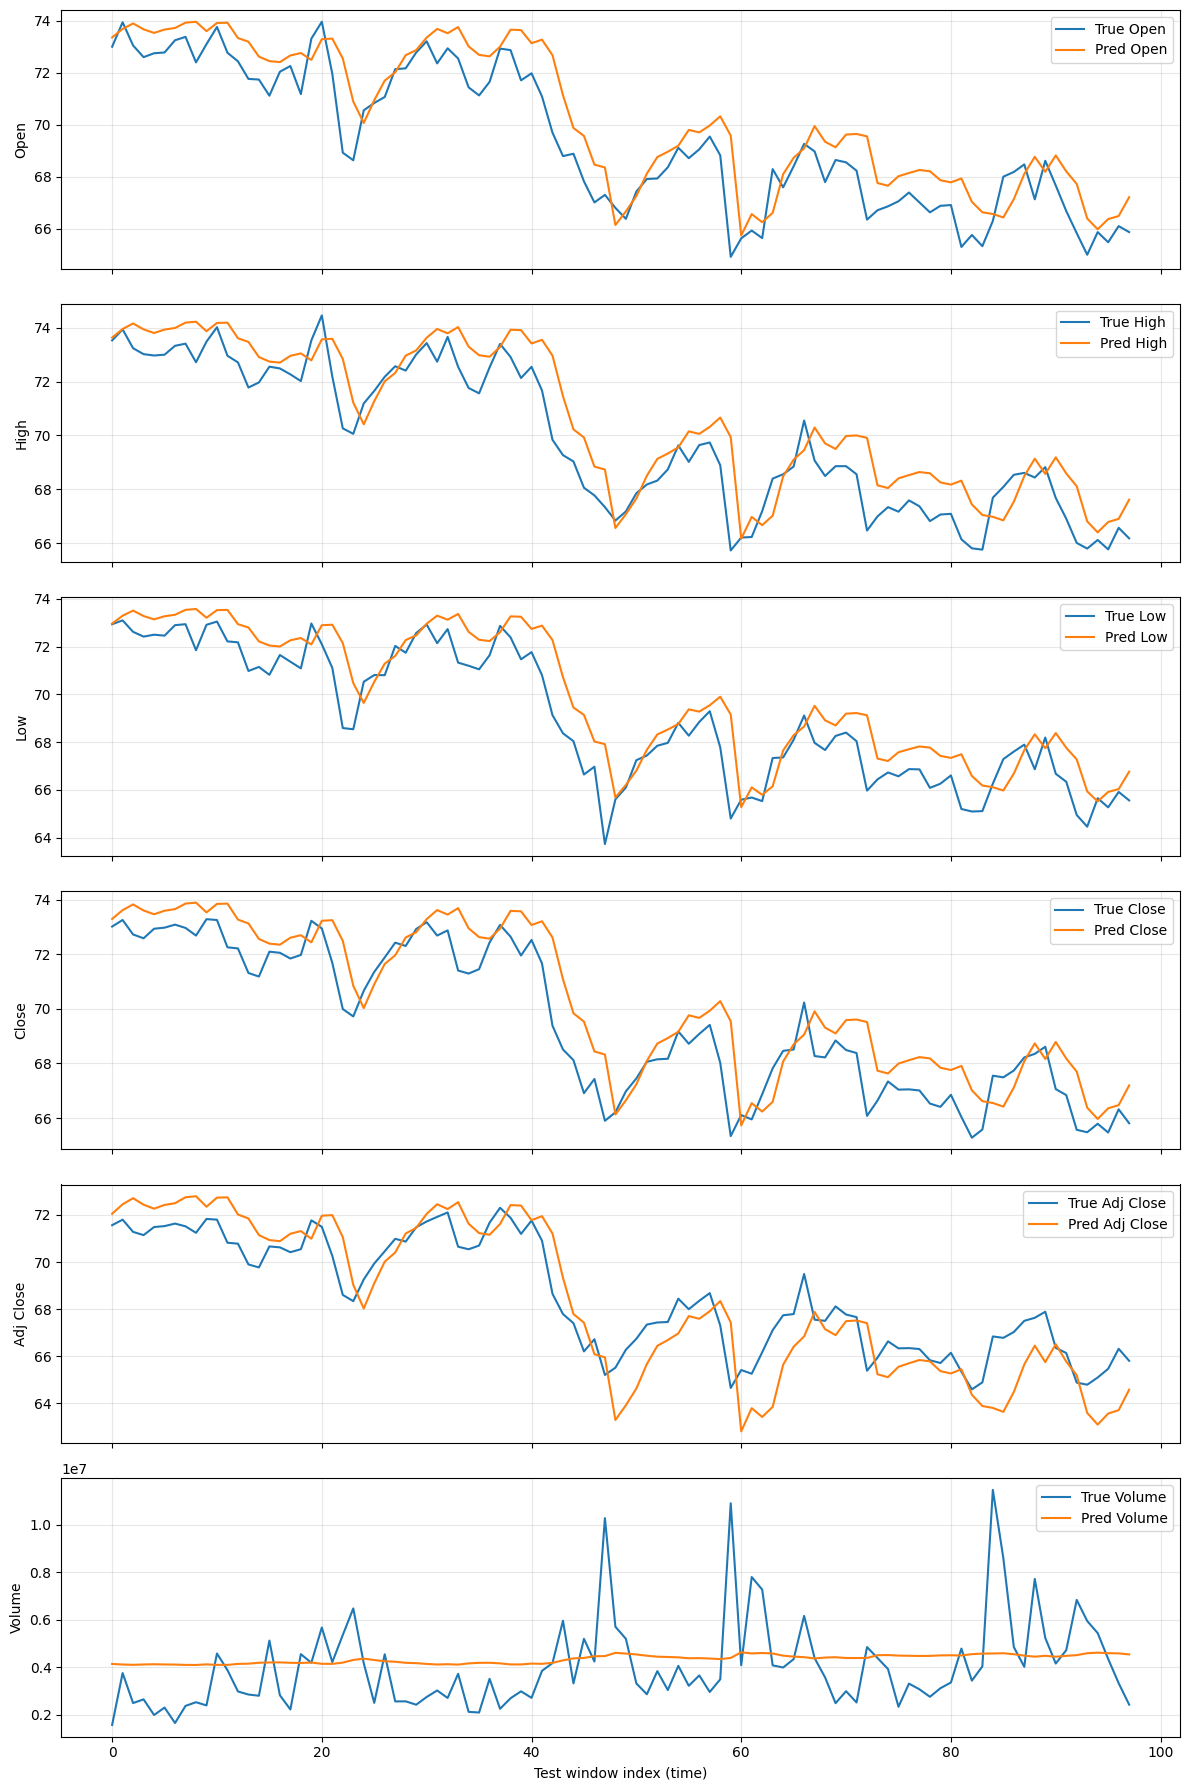

In [33]:

plot_overlays(y_true=y_test_orig, y_pred=preds_orig, feature_names=FEATURE_COLS)

**ATTENTION LSTM SEQ2SEQ**

In [94]:
SEQ_LEN = 30
OUTPUT_LEN = 1
BATCH_SIZE = 32
EPOCHS = 100
LR = 1e-3
HIDDEN_SIZE = 64

In [95]:
CSV_PATH = "/oak/stanford/groups/rondror/users/nishankr/229proj/data/SHEL_data.csv"
FEATURE_COLS = ["Open","High","Low","Close","Adj Close","Volume"]


In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [97]:
def scaled_rmse(y_true_scaled, y_pred_scaled):
    mse = np.mean((y_true_scaled - y_pred_scaled) ** 2, axis=0)
    rmse = np.sqrt(mse)
    return rmse, float(rmse.mean())

def mape(y_true, y_pred, eps=1e-8):
    denom = np.maximum(np.abs(y_true), eps)
    ape = np.abs((y_pred - y_true) / denom)
    per_feature = ape.mean(axis=0) * 100.0
    overall = float(per_feature.mean())
    return per_feature, overall

def mean_directional_accuracy(y_true, y_pred, full_series, target_indices):
    prev_idx = target_indices - 1
    prev_vals = full_series[prev_idx]
    actual_change = np.sign(y_true - prev_vals)
    pred_change   = np.sign(y_pred - prev_vals)
    mask = actual_change != 0
    matches = (actual_change == pred_change) & mask
    per_feature = np.zeros(y_true.shape[1])
    for d in range(y_true.shape[1]):
        if mask[:, d].sum() == 0:
            per_feature[d] = np.nan
        else:
            per_feature[d] = matches[:, d].sum() / mask[:, d].sum()
    overall = matches.sum() / np.maximum(mask.sum(), 1)
    return per_feature, float(overall)

def r2_score_multi(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2, axis=0)
    ss_tot = np.sum((y_true - y_true.mean(axis=0)) ** 2, axis=0)
    per_feature = 1.0 - ss_res / ss_tot
    overall = 1.0 - ss_res.sum() / ss_tot.sum()
    return per_feature, float(overall)

def forecast_bias(y_true, y_pred, tol_frac=0.01):
    errors = y_pred - y_true
    mean_err = errors.mean(axis=0)
    mean_abs = np.mean(np.abs(y_true), axis=0) + 1e-8
    labels = []
    for m, ma in zip(mean_err, mean_abs):
        tol = tol_frac * ma
        if m > tol:
            labels.append("Positive bias (over-forecast)")
        elif m < -tol:
            labels.append("Negative bias (under-forecast)")
        else:
            labels.append("Near-unbiased")
    return mean_err, labels

def plot_overlays(y_true, y_pred, feature_names):
    n_features = y_true.shape[1]
    x = np.arange(y_true.shape[0])
    fig, axes = plt.subplots(n_features, 1, figsize=(12, 3 * n_features), sharex=True)
    if n_features == 1:
        axes = [axes]
    for i, ax in enumerate(axes):
        ax.plot(x, y_true[:, i], label=f"True {feature_names[i]}")
        ax.plot(x, y_pred[:, i], label=f"Pred {feature_names[i]}")
        ax.set_ylabel(feature_names[i])
        ax.grid(True, alpha=0.3)
        ax.legend(loc="best")
    axes[-1].set_xlabel("Test window index (time)")
    fig.tight_layout()
    plt.show()

In [98]:
df = pd.read_csv(CSV_PATH, parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

values = df[FEATURE_COLS].values.astype(np.float32)
T, D = values.shape
print("Total timesteps:", T, "Features:", D)

split_idx = int(T * 0.9)

scaler = StandardScaler()
scaler.fit(values[:split_idx])
values_scaled = scaler.transform(values).astype(np.float32)

Total timesteps: 977 Features: 6


In [99]:
X_list, y_list, idx_list = [], [], []
for t in range(SEQ_LEN, T - OUTPUT_LEN + 1):
    X_list.append(values_scaled[t - SEQ_LEN : t])
    y_list.append(values_scaled[t : t + OUTPUT_LEN].reshape(-1, D))
    idx_list.append(t)

X = np.stack(X_list, axis=0)
y = np.stack(y_list, axis=0)
indices = np.array(idx_list)

train_mask = indices < split_idx
test_mask  = indices >= split_idx

In [100]:
X_train, y_train, idx_train = X[train_mask], y[train_mask, 0, :], indices[train_mask]
X_test,  y_test,  idx_test  = X[test_mask],  y[test_mask, 0, :],  indices[test_mask]

In [101]:
print("Train windows:", X_train.shape[0], "Test windows:", X_test.shape[0])

Train windows: 849 Test windows: 98


In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [103]:
model = AttentionLSTMSeq2Seq(
    input_size=D,
    output_size=D,
    hidden_size=HIDDEN_SIZE,
    num_layers=1,
    bidirectional=False,
    dropout=0.0,
).to(device)

optim = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

In [104]:

train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

In [105]:
model.train()
for epoch in range(1, EPOCHS + 1):
    epoch_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optim.zero_grad()
        preds = model(xb, 1)
        preds = preds[:, 0, :]
        loss = loss_fn(preds, yb)
        loss.backward()
        optim.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_ds)
    print(f"Epoch {epoch:03d} | Train MSE: {epoch_loss:.6f}")

Epoch 001 | Train MSE: 0.879124
Epoch 002 | Train MSE: 0.338475
Epoch 003 | Train MSE: 0.230868
Epoch 004 | Train MSE: 0.216595
Epoch 005 | Train MSE: 0.215153
Epoch 006 | Train MSE: 0.214210
Epoch 007 | Train MSE: 0.213255
Epoch 008 | Train MSE: 0.210517
Epoch 009 | Train MSE: 0.207074
Epoch 010 | Train MSE: 0.205411
Epoch 011 | Train MSE: 0.203244
Epoch 012 | Train MSE: 0.202774
Epoch 013 | Train MSE: 0.200927
Epoch 014 | Train MSE: 0.200952
Epoch 015 | Train MSE: 0.200086
Epoch 016 | Train MSE: 0.198195
Epoch 017 | Train MSE: 0.197408
Epoch 018 | Train MSE: 0.196837
Epoch 019 | Train MSE: 0.195636
Epoch 020 | Train MSE: 0.195371
Epoch 021 | Train MSE: 0.195139
Epoch 022 | Train MSE: 0.192970
Epoch 023 | Train MSE: 0.191960
Epoch 024 | Train MSE: 0.192621
Epoch 025 | Train MSE: 0.192067
Epoch 026 | Train MSE: 0.189856
Epoch 027 | Train MSE: 0.189678
Epoch 028 | Train MSE: 0.188617
Epoch 029 | Train MSE: 0.190578
Epoch 030 | Train MSE: 0.189246
Epoch 031 | Train MSE: 0.187599
Epoch 03

In [106]:
model.eval()
with torch.no_grad():
    X_t = torch.from_numpy(X_test).to(device)
    preds = model(X_t, 1).cpu().numpy()
    preds = preds[:, 0, :]

y_test_scaled = y_test
preds_scaled = preds


y_test_orig = scaler.inverse_transform(y_test_scaled)
preds_orig  = scaler.inverse_transform(preds_scaled)

full_orig = values 

In [107]:
rmse_sf, rmse_overall = scaled_rmse(y_test_scaled, preds_scaled)
mape_pf, mape_overall = mape(y_test_orig, preds_orig)
mda_pf, mda_overall = mean_directional_accuracy(
    y_test_orig, preds_orig, full_orig, idx_test
)
r2_pf, r2_overall = r2_score_multi(y_test_orig, preds_orig)
mean_err_pf, bias_labels = forecast_bias(y_test_orig, preds_orig)

print("\n=== HOLDOUT METRICS (Seq2Seq LSTM) ===")
for i, name in enumerate(FEATURE_COLS):
    print(f"\nFeature: {name}")
    print(f"  Scaled RMSE: {rmse_sf[i]:.4f}")
    print(f"  MAPE:        {mape_pf[i]:.2f}%")
    print(f"  MDA:         {mda_pf[i]:.3f}")
    print(f"  R^2:         {r2_pf[i]:.3f}")
    print(f"  Mean error:  {mean_err_pf[i]:.4f}  -> {bias_labels[i]}")


=== HOLDOUT METRICS (Seq2Seq LSTM) ===

Feature: Open
  Scaled RMSE: 0.1462
  MAPE:        1.78%
  MDA:         0.561
  R^2:         0.701
  Mean error:  -0.1867  -> Near-unbiased

Feature: High
  Scaled RMSE: 0.1428
  MAPE:        1.77%
  MDA:         0.474
  R^2:         0.709
  Mean error:  -0.2395  -> Near-unbiased

Feature: Low
  Scaled RMSE: 0.1492
  MAPE:        1.80%
  MDA:         0.500
  R^2:         0.698
  Mean error:  -0.1322  -> Near-unbiased

Feature: Close
  Scaled RMSE: 0.1414
  MAPE:        1.79%
  MDA:         0.490
  R^2:         0.714
  Mean error:  -0.2142  -> Near-unbiased

Feature: Adj Close
  Scaled RMSE: 0.1749
  MAPE:        2.32%
  MDA:         0.500
  R^2:         0.356
  Mean error:  -1.3490  -> Negative bias (under-forecast)

Feature: Volume
  Scaled RMSE: 1.0702
  MAPE:        29.68%
  MDA:         0.643
  R^2:         0.047
  Mean error:  -71540.0469  -> Negative bias (under-forecast)


In [108]:
def make_results_row(model_name, y_true_scaled, y_pred_scaled,
                     y_true_orig, y_pred_orig,
                     full_orig_series, test_indices):
    """
    model_name: str, e.g. "Seq2Seq_LSTM"
    y_true_scaled, y_pred_scaled: numpy arrays, shape (N_test, D)
    y_true_orig,   y_pred_orig:   numpy arrays, shape (N_test, D)  (un-scaled)
    full_orig_series: full data series in original units, shape (T, D)
    test_indices: 1D array, length N_test, giving the index in full_orig_series
                  for each y_true row (so MDA can compute sign change from previous timestep)
    Returns:
      dict with keys:
        "Model", "Scaled RMSE", "MAPE", "Mean Directional Accuracy (MDA)", "R^2", "Forecast Bias?"
    """
    import numpy as np

    
    mse = np.mean((y_true_scaled - y_pred_scaled) ** 2, axis=0)
    rmse_series = np.sqrt(mse)
    scaled_rmse = float(rmse_series.mean())

    
    eps = 1e-8
    ape = np.abs((y_pred_orig - y_true_orig) / np.maximum(np.abs(y_true_orig), eps))
    mape_per_feat = np.mean(ape, axis=0) * 100.0
    mape = float(np.mean(mape_per_feat))

    
    ss_res = np.sum((y_true_orig - y_pred_orig) ** 2)
    ss_tot = np.sum((y_true_orig - y_true_orig.mean(axis=0)) ** 2)
    r2 = 1.0 - ss_res / (ss_tot + eps)

   
    mean_err = np.mean(y_pred_orig - y_true_orig)
    bias_label = "Over-forecast (too high)" if mean_err > 0 else "Under-forecast (too low)" if mean_err < 0 else "Unbiased"

    
    prev_idx = test_indices - 1
    prev_vals = full_orig_series[prev_idx]
    actual_change = np.sign(y_true_orig - prev_vals)
    pred_change   = np.sign(y_pred_orig - prev_vals)
    mask = actual_change != 0
    matches = (actual_change == pred_change) & mask
    
    mda = matches.sum() / max(mask.sum(), 1)

    return {
        "Model": model_name,
        "Scaled RMSE": scaled_rmse,
        "MAPE": mape,
        "Mean Directional Accuracy (MDA)": float(mda),
        "R^2": r2,
        "Forecast Bias?": bias_label
    }

In [109]:
row = make_results_row(
    "Seq2Seq_LSTM",
    y_test_scaled, preds_scaled,
    y_test_orig, preds_orig,
    full_orig, idx_test
)
print(row)

{'Model': 'Seq2Seq_LSTM', 'Scaled RMSE': 0.3041229546070099, 'MAPE': 6.522828578948975, 'Mean Directional Accuracy (MDA)': 0.5281090289608177, 'R^2': np.float32(0.04728794), 'Forecast Bias?': 'Under-forecast (too low)'}


In [110]:
print("\nOverall (all features combined):")
print(f"  Scaled RMSE (mean): {rmse_overall:.4f}")
print(f"  MAPE (mean):        {mape_overall:.2f}%")
print(f"  MDA (overall):      {mda_overall:.3f}")
print(f"  R^2 (overall):      {r2_overall:.3f}")



Overall (all features combined):
  Scaled RMSE (mean): 0.3041
  MAPE (mean):        6.52%
  MDA (overall):      0.528
  R^2 (overall):      0.047


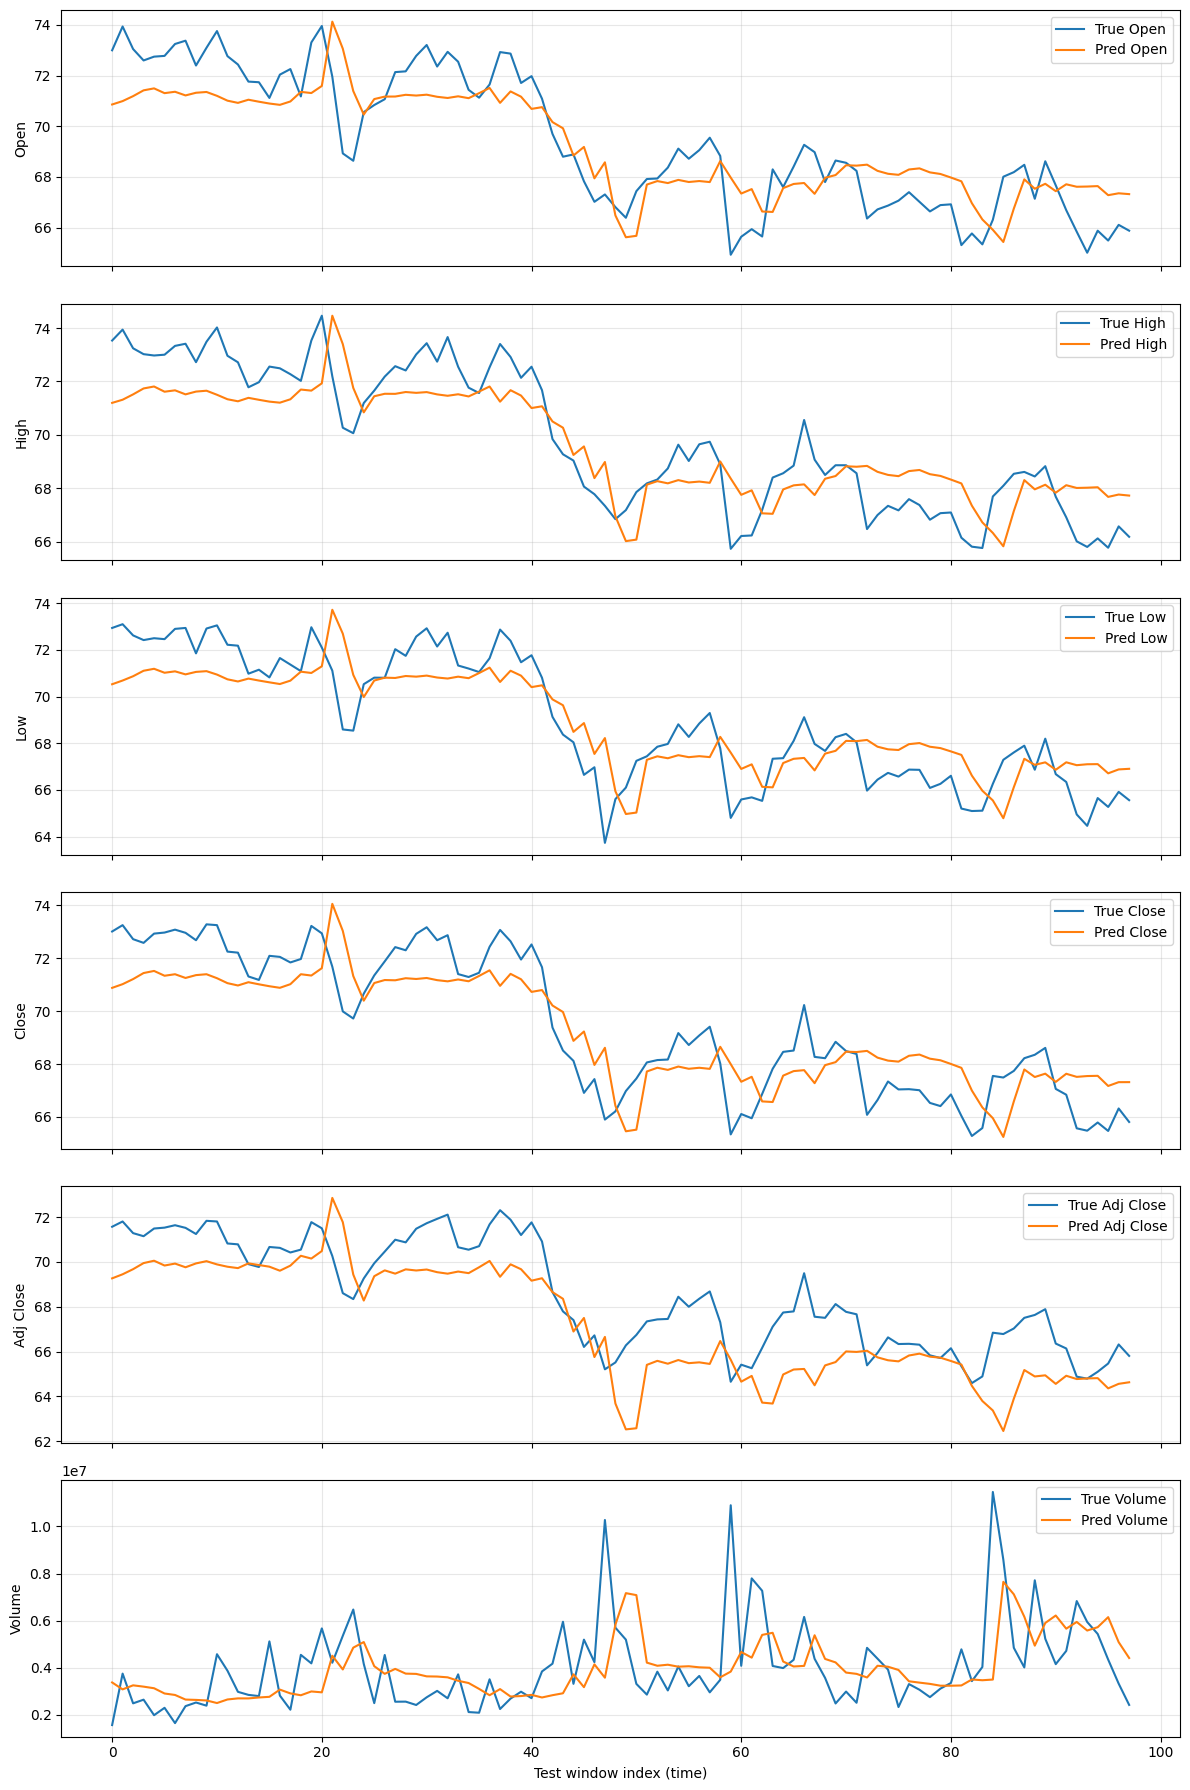

In [111]:

plot_overlays(y_true=y_test_orig, y_pred=preds_orig, feature_names=FEATURE_COLS)

**TRANSFORMER LSTM SEQ2SEQ**

In [113]:
SEQ_LEN = 30
OUTPUT_LEN = 1
BATCH_SIZE = 32
EPOCHS = 100
LR = 1e-3
HIDDEN_SIZE = 64

In [114]:
CSV_PATH = "/oak/stanford/groups/rondror/users/nishankr/229proj/data/SHEL_data.csv"
FEATURE_COLS = ["Open","High","Low","Close","Adj Close","Volume"]


In [115]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [116]:
def scaled_rmse(y_true_scaled, y_pred_scaled):
    mse = np.mean((y_true_scaled - y_pred_scaled) ** 2, axis=0)
    rmse = np.sqrt(mse)
    return rmse, float(rmse.mean())

def mape(y_true, y_pred, eps=1e-8):
    denom = np.maximum(np.abs(y_true), eps)
    ape = np.abs((y_pred - y_true) / denom)
    per_feature = ape.mean(axis=0) * 100.0
    overall = float(per_feature.mean())
    return per_feature, overall

def mean_directional_accuracy(y_true, y_pred, full_series, target_indices):
    prev_idx = target_indices - 1
    prev_vals = full_series[prev_idx]
    actual_change = np.sign(y_true - prev_vals)
    pred_change   = np.sign(y_pred - prev_vals)
    mask = actual_change != 0
    matches = (actual_change == pred_change) & mask
    per_feature = np.zeros(y_true.shape[1])
    for d in range(y_true.shape[1]):
        if mask[:, d].sum() == 0:
            per_feature[d] = np.nan
        else:
            per_feature[d] = matches[:, d].sum() / mask[:, d].sum()
    overall = matches.sum() / np.maximum(mask.sum(), 1)
    return per_feature, float(overall)

def r2_score_multi(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2, axis=0)
    ss_tot = np.sum((y_true - y_true.mean(axis=0)) ** 2, axis=0)
    per_feature = 1.0 - ss_res / ss_tot
    overall = 1.0 - ss_res.sum() / ss_tot.sum()
    return per_feature, float(overall)

def forecast_bias(y_true, y_pred, tol_frac=0.01):
    errors = y_pred - y_true
    mean_err = errors.mean(axis=0)
    mean_abs = np.mean(np.abs(y_true), axis=0) + 1e-8
    labels = []
    for m, ma in zip(mean_err, mean_abs):
        tol = tol_frac * ma
        if m > tol:
            labels.append("Positive bias (over-forecast)")
        elif m < -tol:
            labels.append("Negative bias (under-forecast)")
        else:
            labels.append("Near-unbiased")
    return mean_err, labels

def plot_overlays(y_true, y_pred, feature_names):
    n_features = y_true.shape[1]
    x = np.arange(y_true.shape[0])
    fig, axes = plt.subplots(n_features, 1, figsize=(12, 3 * n_features), sharex=True)
    if n_features == 1:
        axes = [axes]
    for i, ax in enumerate(axes):
        ax.plot(x, y_true[:, i], label=f"True {feature_names[i]}")
        ax.plot(x, y_pred[:, i], label=f"Pred {feature_names[i]}")
        ax.set_ylabel(feature_names[i])
        ax.grid(True, alpha=0.3)
        ax.legend(loc="best")
    axes[-1].set_xlabel("Test window index (time)")
    fig.tight_layout()
    plt.show()

In [117]:
df = pd.read_csv(CSV_PATH, parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

values = df[FEATURE_COLS].values.astype(np.float32)
T, D = values.shape
print("Total timesteps:", T, "Features:", D)

split_idx = int(T * 0.9)

scaler = StandardScaler()
scaler.fit(values[:split_idx])
values_scaled = scaler.transform(values).astype(np.float32)

Total timesteps: 977 Features: 6


In [118]:
X_list, y_list, idx_list = [], [], []
for t in range(SEQ_LEN, T - OUTPUT_LEN + 1):
    X_list.append(values_scaled[t - SEQ_LEN : t])
    y_list.append(values_scaled[t : t + OUTPUT_LEN].reshape(-1, D))
    idx_list.append(t)

X = np.stack(X_list, axis=0)
y = np.stack(y_list, axis=0)
indices = np.array(idx_list)

train_mask = indices < split_idx
test_mask  = indices >= split_idx

In [119]:
X_train, y_train, idx_train = X[train_mask], y[train_mask, 0, :], indices[train_mask]
X_test,  y_test,  idx_test  = X[test_mask],  y[test_mask, 0, :],  indices[test_mask]

In [120]:
print("Train windows:", X_train.shape[0], "Test windows:", X_test.shape[0])

Train windows: 849 Test windows: 98


In [121]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [125]:
model = TransformerSeq2Seq(
    input_size=D,
    output_size=D,
    num_layers=1,
    dropout=0.0,
).to(device)

optim = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

In [126]:

train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

In [127]:
model.train()
for epoch in range(1, EPOCHS + 1):
    epoch_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optim.zero_grad()
        preds = model(xb, 1)
        preds = preds[:, 0, :]
        loss = loss_fn(preds, yb)
        loss.backward()
        optim.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_ds)
    print(f"Epoch {epoch:03d} | Train MSE: {epoch_loss:.6f}")

Epoch 001 | Train MSE: 1.038793
Epoch 002 | Train MSE: 0.495227
Epoch 003 | Train MSE: 0.219646
Epoch 004 | Train MSE: 0.185488
Epoch 005 | Train MSE: 0.186690
Epoch 006 | Train MSE: 0.192596
Epoch 007 | Train MSE: 0.200674
Epoch 008 | Train MSE: 0.183280
Epoch 009 | Train MSE: 0.190535
Epoch 010 | Train MSE: 0.174198
Epoch 011 | Train MSE: 0.187516
Epoch 012 | Train MSE: 0.174983
Epoch 013 | Train MSE: 0.183370
Epoch 014 | Train MSE: 0.183505
Epoch 015 | Train MSE: 0.175410
Epoch 016 | Train MSE: 0.184315
Epoch 017 | Train MSE: 0.183293
Epoch 018 | Train MSE: 0.178991
Epoch 019 | Train MSE: 0.182225
Epoch 020 | Train MSE: 0.176499
Epoch 021 | Train MSE: 0.171646
Epoch 022 | Train MSE: 0.179256
Epoch 023 | Train MSE: 0.175512
Epoch 024 | Train MSE: 0.178869
Epoch 025 | Train MSE: 0.188874
Epoch 026 | Train MSE: 0.189196
Epoch 027 | Train MSE: 0.189330
Epoch 028 | Train MSE: 0.185079
Epoch 029 | Train MSE: 0.173732
Epoch 030 | Train MSE: 0.169347
Epoch 031 | Train MSE: 0.176154
Epoch 03

In [128]:
model.eval()
with torch.no_grad():
    X_t = torch.from_numpy(X_test).to(device)
    preds = model(X_t, 1).cpu().numpy()
    preds = preds[:, 0, :]

y_test_scaled = y_test
preds_scaled = preds

y_test_orig = scaler.inverse_transform(y_test_scaled)
preds_orig  = scaler.inverse_transform(preds_scaled)

full_orig = values 

In [129]:
rmse_sf, rmse_overall = scaled_rmse(y_test_scaled, preds_scaled)
mape_pf, mape_overall = mape(y_test_orig, preds_orig)
mda_pf, mda_overall = mean_directional_accuracy(
    y_test_orig, preds_orig, full_orig, idx_test
)
r2_pf, r2_overall = r2_score_multi(y_test_orig, preds_orig)
mean_err_pf, bias_labels = forecast_bias(y_test_orig, preds_orig)

print("\n=== HOLDOUT METRICS (Seq2Seq LSTM) ===")
for i, name in enumerate(FEATURE_COLS):
    print(f"\nFeature: {name}")
    print(f"  Scaled RMSE: {rmse_sf[i]:.4f}")
    print(f"  MAPE:        {mape_pf[i]:.2f}%")
    print(f"  MDA:         {mda_pf[i]:.3f}")
    print(f"  R^2:         {r2_pf[i]:.3f}")
    print(f"  Mean error:  {mean_err_pf[i]:.4f}  -> {bias_labels[i]}")


=== HOLDOUT METRICS (Seq2Seq LSTM) ===

Feature: Open
  Scaled RMSE: 0.2459
  MAPE:        3.04%
  MDA:         0.541
  R^2:         0.155
  Mean error:  1.5291  -> Positive bias (over-forecast)

Feature: High
  Scaled RMSE: 0.2497
  MAPE:        3.01%
  MDA:         0.557
  R^2:         0.111
  Mean error:  1.5456  -> Positive bias (over-forecast)

Feature: Low
  Scaled RMSE: 0.2559
  MAPE:        3.14%
  MDA:         0.561
  R^2:         0.110
  Mean error:  1.6010  -> Positive bias (over-forecast)

Feature: Close
  Scaled RMSE: 0.2390
  MAPE:        2.90%
  MDA:         0.571
  R^2:         0.183
  Mean error:  1.4168  -> Positive bias (over-forecast)

Feature: Adj Close
  Scaled RMSE: 0.1485
  MAPE:        2.04%
  MDA:         0.561
  R^2:         0.536
  Mean error:  0.3526  -> Near-unbiased

Feature: Volume
  Scaled RMSE: 1.0426
  MAPE:        34.42%
  MDA:         0.643
  R^2:         0.096
  Mean error:  92456.0391  -> Positive bias (over-forecast)


In [130]:
def make_results_row(model_name, y_true_scaled, y_pred_scaled,
                     y_true_orig, y_pred_orig,
                     full_orig_series, test_indices):
    """
    model_name: str, e.g. "Seq2Seq_LSTM"
    y_true_scaled, y_pred_scaled: numpy arrays, shape (N_test, D)
    y_true_orig,   y_pred_orig:   numpy arrays, shape (N_test, D)  (un-scaled)
    full_orig_series: full data series in original units, shape (T, D)
    test_indices: 1D array, length N_test, giving the index in full_orig_series
                  for each y_true row (so MDA can compute sign change from previous timestep)
    Returns:
    
      dict with keys:
        "Model", "Scaled RMSE", "MAPE", "Mean Directional Accuracy (MDA)", "R^2", "Forecast Bias?"
    """
    import numpy as np

  
    mse = np.mean((y_true_scaled - y_pred_scaled) ** 2, axis=0)
    rmse_series = np.sqrt(mse)
    scaled_rmse = float(rmse_series.mean())

  
    eps = 1e-8
    ape = np.abs((y_pred_orig - y_true_orig) / np.maximum(np.abs(y_true_orig), eps))
    mape_per_feat = np.mean(ape, axis=0) * 100.0
    mape = float(np.mean(mape_per_feat))


    ss_res = np.sum((y_true_orig - y_pred_orig) ** 2)
    ss_tot = np.sum((y_true_orig - y_true_orig.mean(axis=0)) ** 2)
    r2 = 1.0 - ss_res / (ss_tot + eps)


    mean_err = np.mean(y_pred_orig - y_true_orig)
    bias_label = "Over-forecast (too high)" if mean_err > 0 else "Under-forecast (too low)" if mean_err < 0 else "Unbiased"


    prev_idx = test_indices - 1
    prev_vals = full_orig_series[prev_idx]
    actual_change = np.sign(y_true_orig - prev_vals)
    pred_change   = np.sign(y_pred_orig - prev_vals)
    mask = actual_change != 0
    matches = (actual_change == pred_change) & mask

    mda = matches.sum() / max(mask.sum(), 1)

    return {
        "Model": model_name,
        "Scaled RMSE": scaled_rmse,
        "MAPE": mape,
        "Mean Directional Accuracy (MDA)": float(mda),
        "R^2": r2,
        "Forecast Bias?": bias_label
    }

In [131]:
row = make_results_row(
    "TransformerSeq2Seq_LSTM",
    y_test_scaled, preds_scaled,
    y_test_orig, preds_orig,
    full_orig, idx_test
)
print(row)

{'Model': 'TransformerSeq2Seq_LSTM', 'Scaled RMSE': 0.36360129714012146, 'MAPE': 8.092142105102539, 'Mean Directional Accuracy (MDA)': 0.5724020442930153, 'R^2': np.float32(0.095721304), 'Forecast Bias?': 'Over-forecast (too high)'}


In [ ]:
print("\nOverall (all features combined):")
print(f"  Scaled RMSE (mean): {rmse_overall:.4f}")
print(f"  MAPE (mean):        {mape_overall:.2f}%")
print(f"  MDA (overall):      {mda_overall:.3f}")
print(f"  R^2 (overall):      {r2_overall:.3f}")



Overall (all features combined):
  Scaled RMSE (mean): 0.3041
  MAPE (mean):        6.52%
  MDA (overall):      0.528
  R^2 (overall):      0.047


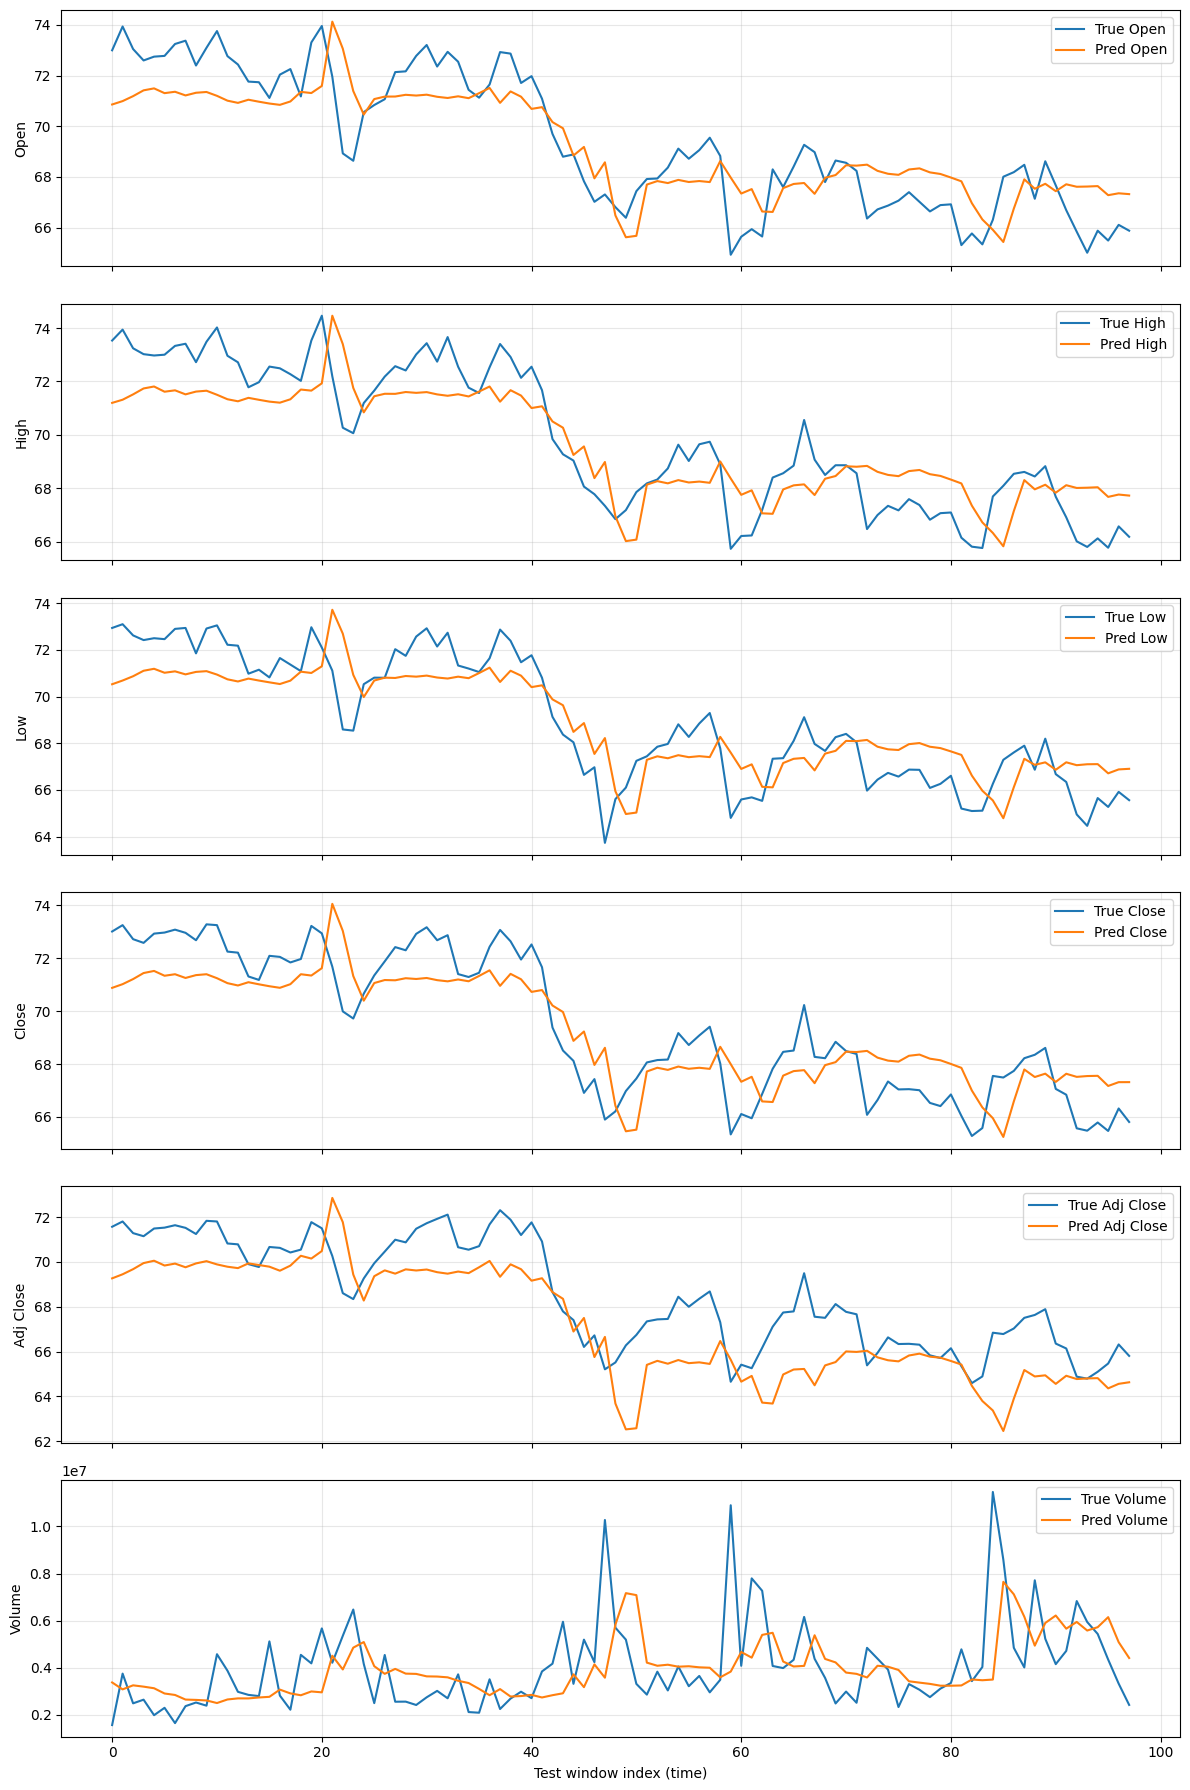

In [ ]:

plot_overlays(y_true=y_test_orig, y_pred=preds_orig, feature_names=FEATURE_COLS)